In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

FILE_PATH = "BrightHR absence report Nov-Dec.xlsx"

In [17]:
# 1) Read the report properly (table header is on row 15 in Excel; header=14 0-indexed)
df = pd.read_excel(FILE_PATH, sheet_name="in", header=14)

# Drop blank rows (real data always has First Name filled)
df = df[df["First Name"].notna()].copy()

print("Shape:", df.shape)
print("\nColumns:\n", df.columns.tolist())


Shape: (127, 30)

Columns:
 ['First Name', 'Middle Name', 'Last Name', 'Team(s)', 'Job Title', 'Contract Type', 'Employment Type', 'Is Terminated', 'Payroll Number', 'Customer Integration Reference', 'Absence Type', 'Absence Status', 'Description', 'Is Paid', 'Paid Duration', 'Is Certified', 'Logged Date', 'Logged By', 'Approved At', 'Approved By', 'Employee Hired On', 'Start Date', 'End Date', 'Total Duration of Absence (Days)', 'Total Duration of Absence (Hours)', 'Duration Within Report Date Range (Days)', 'Duration Within Report Date Range (Hours)', 'Ongoing', 'Total Duration of Absence (Decimal Hours)', 'Duration Within Report Date Range (Decimal Hours)']


In [18]:
# 2) Basic cleaning / helpful fields
for c in ["First Name", "Middle Name", "Last Name", "Team(s)", "Absence Type", "Absence Status", "Description"]:
    if c in df.columns:
        df[c] = df[c].astype(str).str.strip()

df["employee_name"] = (
    df["First Name"].fillna("").astype(str).str.strip() + " " +
    df["Last Name"].fillna("").astype(str).str.strip()
).str.strip()

df["start_date"] = pd.to_datetime(df["Start Date"], errors="coerce")
df["end_date"] = pd.to_datetime(df["End Date"], errors="coerce")

# Use "within report range" duration for Nov-Dec dashboard KPIs
DUR_COL = "Duration Within Report Date Range (Days)"
df["duration_days"] = pd.to_numeric(df[DUR_COL], errors="coerce")

# Sanity checks
print("\nMissing start dates:", df["start_date"].isna().sum())
print("Missing end dates:", df["end_date"].isna().sum())
print("Missing duration:", df["duration_days"].isna().sum())
print("Negative duration rows:", (df["duration_days"] < 0).sum())

# Time buckets for trends
df["month"] = df["start_date"].dt.to_period("M").astype(str)
df["week"] = df["start_date"].dt.to_period("W").astype(str)
df["day_of_week"] = df["start_date"].dt.day_name()

# Helpful flags
df["short_term_flag"] = df["duration_days"] <= 7


Missing start dates: 1
Missing end dates: 1
Missing duration: 1
Negative duration rows: 0


In [19]:
# 3) High-level KPIs
kpis = {
    "total_cases": len(df),
    "unique_employees": df["employee_name"].nunique(),
    "total_absence_days_in_period": df["duration_days"].sum(),
    "avg_days_per_case": df["duration_days"].mean(),
    "pct_short_term_cases": df["short_term_flag"].mean() * 100,
}
print("\nKPIs:")
for k, v in kpis.items():
    print(f"  {k}: {v}")


KPIs:
  total_cases: 127
  unique_employees: 64
  total_absence_days_in_period: 116.5
  avg_days_per_case: 0.9246031746031746
  pct_short_term_cases: 99.21259842519686


In [20]:
# 4) Core summaries for dashboard tiles/charts
by_month = df.groupby("month")["duration_days"].sum().sort_index()
by_team = df.groupby("Team(s)")["duration_days"].sum().sort_values(ascending=False)
by_type = df.groupby("Absence Type")["duration_days"].sum().sort_values(ascending=False)
by_status = df.groupby("Absence Status")["duration_days"].sum().sort_values(ascending=False)

cases_per_employee = df.groupby("employee_name").size().sort_values(ascending=False)
days_per_employee = df.groupby("employee_name")["duration_days"].sum().sort_values(ascending=False)

print("\nAbsence days by month:\n", by_month)
print("\nTop teams by absence days:\n", by_team.head(10))
print("\nAbsence days by type:\n", by_type)
print("\nAbsence days by status:\n", by_status)
print("\nTop employees by cases:\n", cases_per_employee.head(10))
print("\nTop employees by days:\n", days_per_employee.head(10))


Absence days by month:
 month
2026-12    116.5
NaT          0.0
Name: duration_days, dtype: float64

Top teams by absence days:
 Team(s)
Agriculture                18.0
UK Development             17.0
Finance                    12.0
DE Business Development    11.5
Engineering                 8.0
Group Finance               8.0
Legal                       8.0
Operations                  8.0
Business Support            6.0
Investment                  6.0
Name: duration_days, dtype: float64

Absence days by type:
 Absence Type
Public holiday     105.0
Mandatory leave      8.0
Annual leave         3.5
nan                  0.0
Name: duration_days, dtype: float64

Absence days by status:
 Absence Status
Approved    113.0
Pending       3.5
nan           0.0
Name: duration_days, dtype: float64

Top employees by cases:
 employee_name
Michaela Gerber      3
Amine El Fassi       2
Selin Bakare         2
Mark Turner          2
Max Kinghorn         2
Michael Zimmerman    2
Nidhi Daga           2
N

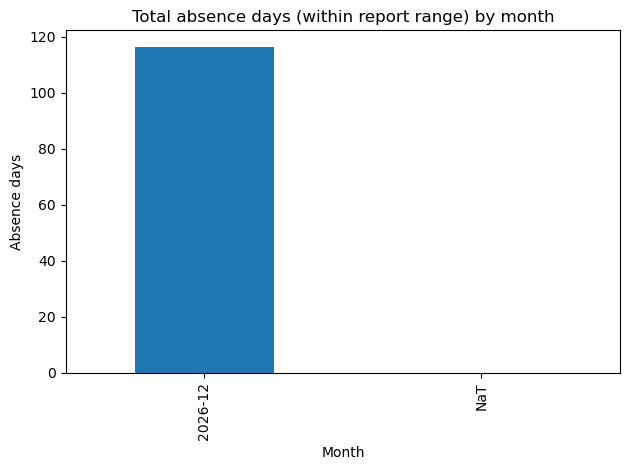

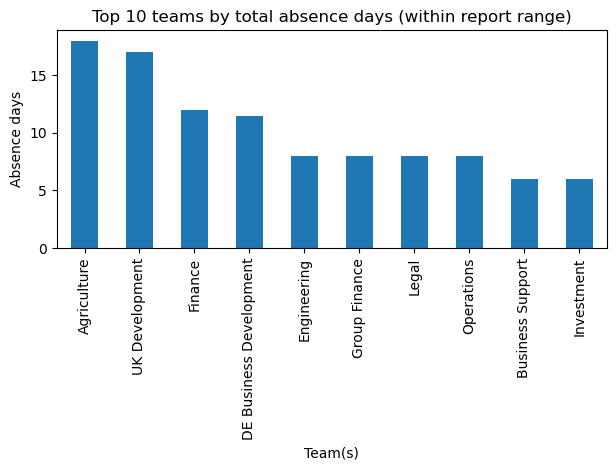

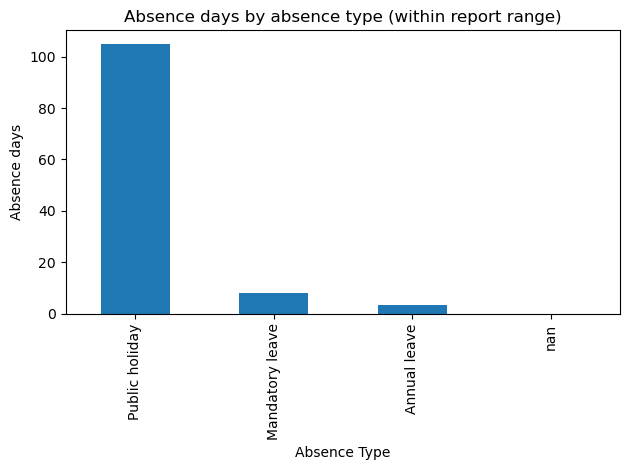

In [21]:
# 5) Basic plots (quick EDA visuals)
by_month.plot(kind="bar", title="Total absence days (within report range) by month")
plt.xlabel("Month")
plt.ylabel("Absence days")
plt.tight_layout()
plt.show()

by_team.head(10).plot(kind="bar", title="Top 10 teams by total absence days (within report range)")
plt.xlabel("Team(s)")
plt.ylabel("Absence days")
plt.tight_layout()
plt.show()

by_type.plot(kind="bar", title="Absence days by absence type (within report range)")
plt.xlabel("Absence Type")
plt.ylabel("Absence days")
plt.tight_layout()
plt.show()


In [22]:
# 6) Export a dashboard-ready dataset
df.to_csv("absence_modelled_nov_dec.csv", index=False)
print("\nSaved: absence_modelled_nov_dec.csv")


Saved: absence_modelled_nov_dec.csv


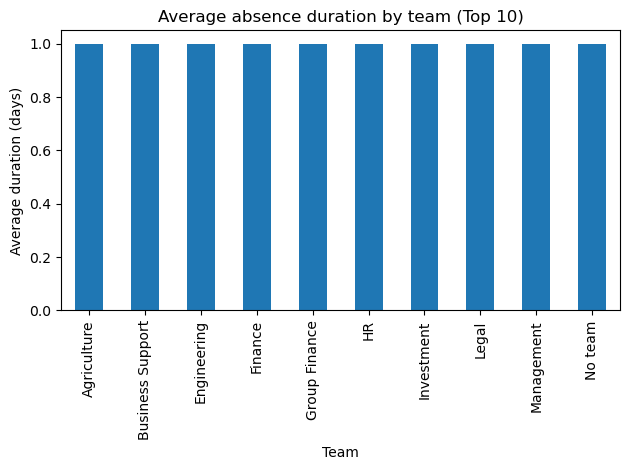

In [23]:
avg_duration_by_team = (
    df.groupby("Team(s)")["duration_days"]
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

avg_duration_by_team.plot(
    kind="bar",
    title="Average absence duration by team (Top 10)"
)
plt.xlabel("Team")
plt.ylabel("Average duration (days)")
plt.tight_layout()
plt.show()


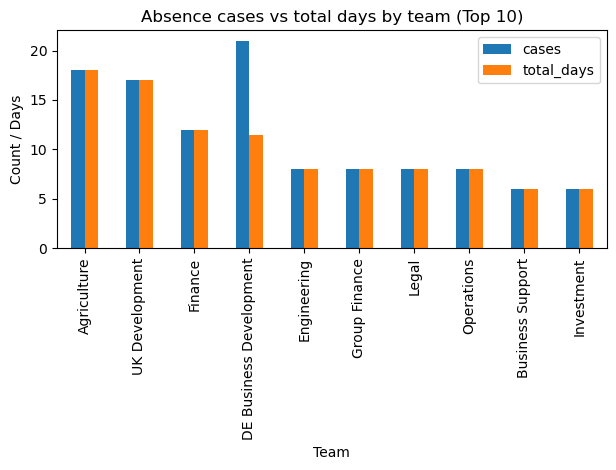

In [24]:
team_cases = df.groupby("Team(s)").size()
team_days = df.groupby("Team(s)")["duration_days"].sum()

team_compare = (
    pd.DataFrame({
        "cases": team_cases,
        "total_days": team_days
    })
    .sort_values("total_days", ascending=False)
    .head(10)
)

team_compare.plot(
    kind="bar",
    title="Absence cases vs total days by team (Top 10)"
)
plt.xlabel("Team")
plt.ylabel("Count / Days")
plt.tight_layout()
plt.show()


----------------------------------------------------------------------------------------------------------------

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("Absence report_20260120_1208.csv")

# Parse dates
df["Absence start date"] = pd.to_datetime(df["Absence start date"], errors="coerce")

# Core dimensions
df["employee"] = (
    df["First name"].fillna("").str.strip() + " " +
    df["Last name"].fillna("").str.strip()
).str.strip()

df["department"] = df["Team names"].fillna("Unknown")

# Metric we will use (THIS is the KPI)
df["absence_days"] = (
    pd.to_numeric(df["Absence duration for period in days"], errors="coerce")
    .fillna(0)
)

# Month (simple – for grouping only)
df["month"] = df["Absence start date"].dt.to_period("M").astype(str)

df.head()


,First name,Last name,Team names,Leave allowance,Leave entitlement,Entitlement unit,Absence type,Absence duration total in days,Absence duration for period in days,Absence description,...,Is ongoing,Fit note required,Estimated return date,Sickness start date type,Sickness end date type,Toil notes,employee,department,absence_days,month
0,Stefanie,Lenehan,HR,NaN,20.0,days,Other,4.0,4.0,Pre-agreed WFH days,...,False,NaN,NaN,NaN,NaN,NaN,Stefanie Lenehan,HR,4.0,2025-07
1,Stefanie,Lenehan,HR,NaN,20.0,days,Other,1.0,1.0,WFH,...,False,NaN,NaN,NaN,NaN,NaN,Stefanie Lenehan,HR,1.0,2025-09
2,Stefanie,Lenehan,HR,NaN,20.0,days,Sickness,1.0,1.0,NaN,...,False,False,NaN,UNKNOWN,UNKNOWN,NaN,Stefanie Lenehan,HR,1.0,2025-04
3,Stefanie,Lenehan,HR,NaN,20.0,days,Other,1.0,1.0,WFH,...,False,NaN,NaN,NaN,NaN,NaN,Stefanie Lenehan,HR,1.0,2025-11
4,Stefanie,Lenehan,HR,NaN,20.0,days,Other,1.0,1.0,NaN,...,False,NaN,NaN,NaN,NaN,NaN,Stefanie Lenehan,HR,1.0,2025-01


In [31]:
def map_absence_type(row):
    t = str(row["Absence type"]).lower()
    d = str(row["Absence description"]).lower()

    if "annual" in t:
        return "Annual leave"

    if "sickness" in t or "medical" in t:
        return "Medical appointment + Sickness"

    if "wfh" in d or "work from home" in d:
        return "WFH"

    if "travel" in t:
        return "Travel"

    return "Other (exc. WFH, Travel)"

df["reporting_absence_type"] = df.apply(map_absence_type, axis=1)

df["reporting_absence_type"].value_counts()


reporting_absence_type
Annual leave                      483
WFH                               224
Other (exc. WFH, Travel)          177
Medical appointment + Sickness     38
Name: count, dtype: int64

In [32]:
target_months = ["2026-11", "2026-12"]
df_target = df[df["month"].isin(target_months)].copy()

# If Nov/Dec not present, use latest two months as MOCK
if df_target.empty:
    latest_months = sorted(df["month"].dropna().unique())[-2:]
    df_target = df[df["month"].isin(latest_months)].copy()
    target_months = latest_months
    print(f"⚠️ Using mock months: {target_months}")

df_target["month"].value_counts().sort_index()


month
2026-12    1
Name: count, dtype: int64

In [33]:
kpis = df_target.groupby("month").agg(
    total_absence_days=("absence_days", "sum"),
    absence_cases=("absence_days", "size"),
    people=("employee", "nunique")
).reset_index()

kpis


,month,total_absence_days,absence_cases,people
0,2026-12,3.5,1,1


In [34]:
dept_summary = df_target.groupby(
    ["month", "department", "reporting_absence_type"]
).agg(
    absence_days=("absence_days", "sum")
).reset_index()

dept_summary.head()


,month,department,reporting_absence_type,absence_days
0,2026-12,DE Business Development,Annual leave,3.5


In [37]:
ind_summary = df_target.groupby(
    ["month", "employee", "department"]
).agg(
    absence_days=("absence_days", "sum")
).reset_index()

ind_pivot = ind_summary.pivot_table(
    index=["employee", "department"],
    columns="month",
    values="absence_days",
    fill_value=0
).reset_index()

if len(target_months) == 2:
    ind_pivot["change_days"] = ind_pivot[target_months[1]] - ind_pivot[target_months[0]]

ind_pivot.sort_values("change_days", ascending=False).head(10)


KeyError: '2026-11'

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------
# 1. Date & month preparation
# ----------------------------
df['Absence start date'] = pd.to_datetime(df['Absence start date'])
df['month'] = df['Absence start date'].dt.to_period('M')

df_25 = df[df['month'].isin(['2025-11', '2025-12'])].copy()
df_25['month_label'] = df_25['month'].astype(str)

# ----------------------------
# 2. Absence type mapping
# ----------------------------
def map_absence_type(x):
    x = str(x).lower()
    if 'annual' in x:
        return 'Annual Leave'
    elif 'sick' in x or 'medical' in x:
        return 'Medical + Sickness'
    elif 'wfh' in x or 'home' in x:
        return 'WFH'
    elif 'travel' in x:
        return 'Travel'
    else:
        return 'Other (excl. WFH, Travel)'

df_25['absence_category'] = df_25['Absence type'].apply(map_absence_type)

# ----------------------------
# 3. KPI calculations
# ----------------------------
kpi = (
    df_25
    .groupby('month_label')['Absence duration for period in days']
    .sum()
)

nov = kpi.get('2025-11', 0)
dec = kpi.get('2025-12', 0)
diff = dec - nov
pct_change = (diff / nov * 100) if nov != 0 else 0

print("KPI SUMMARY")
print(f"Nov 2025 Absence Days: {nov:.1f}")
print(f"Dec 2025 Absence Days: {dec:.1f}")
print(f"Difference (Dec-Nov): {diff:.1f}")
print(f"% Change: {pct_change:.1f}%")

# ----------------------------
# 4. Absence type stacked bar
# ----------------------------
type_summary = (
    df_25
    .groupby(['month_label', 'absence_category'])['Absence duration for period in days']
    .sum()
    .unstack(fill_value=0)
)

type_summary.plot(
    kind='bar',
    stacked=True,
    figsize=(10, 6)
)

plt.title('Absence Days by Type: Nov 2025 vs Dec 2025')
plt.ylabel('Absence Days')
plt.xlabel('')
plt.legend(title='Absence Type', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# ----------------------------
# 5. Department comparison
# ----------------------------
dept_summary = (
    df_25
    .groupby(['Team names', 'month_label'])['Absence duration for period in days']
    .sum()
    .reset_index()
)

plt.figure(figsize=(12, 6))
sns.barplot(
    data=dept_summary,
    x='Team names',
    y='Absence duration for period in days',
    hue='month_label'
)

plt.title('Absence Days by Department: Nov vs Dec 2025')
plt.ylabel('Absence Days')
plt.xlabel('Department')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Month')
plt.tight_layout()
plt.show()

# ----------------------------
# 6. Individual drill-down table
# ----------------------------
individual_summary = (
    df_25
    .groupby(['First name', 'Last name', 'Team names', 'month_label'])
    ['Absence duration for period in days']
    .sum()
    .unstack(fill_value=0)
    .reset_index()
)

individual_summary['Difference (Dec-Nov)'] = (
    individual_summary.get('2025-12', 0) -
    individual_summary.get('2025-11', 0)
)

individual_summary.sort_values(
    'Difference (Dec-Nov)',
    ascending=False
).head(10)


KPI SUMMARY
Nov 2025 Absence Days: 0.0
Dec 2025 Absence Days: 0.0
Difference (Dec-Nov): 0.0
% Change: 0.0%


TypeError: no numeric data to plot